### Part 1. Exploratory Data Analysis.

#### 1.1 Load the data.

In [30]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.float_format', '{:.2f}'.format)

In [31]:
#df = pd.read_csv('groupon.txt', sep=None, engine='python')
#df.to_parquet('groupon.parquet')

In [32]:
df = pd.read_parquet('groupon.parquet')

In [33]:
df.head()

,refund_bucket,refund_sub_bucket,order_date,transaction_date,week_end_date,dmm_subcat_1,category_1,deal_supply_channel,buyer_name_1,auth_bookings,capture_bookings,refunds,cancel_refunds,refunded_units,auth_refunds,capture_units
0,Other,Other,8/4/2016,8/4/2016,8/7/2016,Inverse Normal,Probability distribution II,Goods Stores,Asher,?,?,91.87,?,3,?,?
1,Returns,Change of mind,8/31/2018,9/21/2018,9/23/2018,Binomial Distribution.,Probability distribution I,Goods,Jesus,?,?,20.98,?,1,?,?
2,Fraud,Fraud,4/19/2017,4/19/2017,4/23/2017,Power series,Calculus II,Goods,Tristan,?,?,?,79.94,?,?,?
3,Two-Hour Refunds,Two-Hour Refunds,2/5/2016,2/5/2016,2/7/2016,Prime Factorization Algorithms,?,Goods,Jeremiah,?,?,49.267469958,?,1,?,?
4,Shortage Cancellations,Vendor Shortage,7/21/2018,8/15/2018,8/19/2018,Transformations,Geometry,Goods,Jacob,?,?,29.97,?,2,?,?


Our dataframe consists of 16 columns and approximately 6.8 millions rows. The dataframe is huge as it occupies almost 1 GB of memory. Python loaded all columns as objects - so we need to transform data into right data type. The original dictionary with data types description is provided below.

|Column_name	                |Type		|Description
| --- | --- | --- |
|refund_bucket                 	|Varchar	|Reason for refunding customer
|refund_sub_bucket             	|Varchar	|Sub reason for refunding customer
|transaction_date              	|Date		|date of refund
|week_end_date                 	|Date		|weekend date of refund
|dmm_subcat                    	|Varchar	|sub category of product
|category                      	|Varchar	|category of product
|deal_supply_channel           	|Varchar	|channel of sale
|buyer_name                    	|Varchar	|name of buyer who sourced the product
|auth_bookings                 	|Float		|bookings authorized on card
|capture_bookings              	|Float		|bookings captured
|refunds                       	|Float		|amount of refund
|cancel_refunds                	|Float		|refunds if the transaction was a cancellation
|refunded_units                	|Integer	|quantity of product for which refunds were issued
|auth_refunds                  	|Integer	|	
|capture_units                 	|Integer	|	

To allow a faster processing and easy data manipulation let's subset our dataframe to separate one year of transactions and refunds based on a transaction date. I will take 2018 data. 

To do so I need to convert all date's columns to Python date-time format and will use a boolean mask to create a subset.

In [34]:
df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'], infer_datetime_format=True)
df['week_end_date'] = pd.to_datetime(df['week_end_date'], infer_datetime_format=True)

Since I have already converted date's columns to date format, I can set a desired date to filter a dataframe. Then I will assign a mask to dateaframe.

In [35]:
start_date = '2018-01-01'
end_date = '2018-12-31'
mask = (df['transaction_date'] >= start_date) & (df['transaction_date'] <= end_date)
subset = df.loc[mask]
subset.shape

(2162199, 16)

In [36]:
subset = subset.copy()

In [37]:
subset.columns

Index(['refund_bucket', 'refund_sub_bucket', 'order_date', 'transaction_date',
       'week_end_date', 'dmm_subcat_1', 'category_1', 'deal_supply_channel',
       'buyer_name_1', 'auth_bookings', 'capture_bookings', 'refunds',
       'cancel_refunds', 'refunded_units', 'auth_refunds', 'capture_units'],
      dtype='object')

In [38]:
subset.drop(['refund_bucket', 'refund_sub_bucket', 'order_date', 'week_end_date', 
             'dmm_subcat_1', 'category_1', 'deal_supply_channel','buyer_name_1', 
             'auth_bookings','cancel_refunds', 'refunded_units', 'auth_refunds', 
             'capture_units'], axis = 1, inplace = True)

Now let's convert capture_bookings into the float data type.

In [39]:
subset['capture_bookings'] = subset['capture_bookings'].str.replace('?', '0').astype(float)
subset['refunds'] = subset['refunds'].str.replace('?', '0').astype(float)

Let's create year, month, and day columns to plot refund and transaction amounts

In [40]:
variable = pd.DatetimeIndex(subset['transaction_date'])
subset['year'],subset['month'],subset['day'] = variable.year, variable.month, variable.day

In [41]:
avg_data = subset.groupby(['month','day']).agg({'refunds':np.mean,'capture_bookings':np.mean})
avg_data.index = [datetime(2018,month,day) for (month, day) in avg_data.index]

<Figure size 432x288 with 0 Axes>

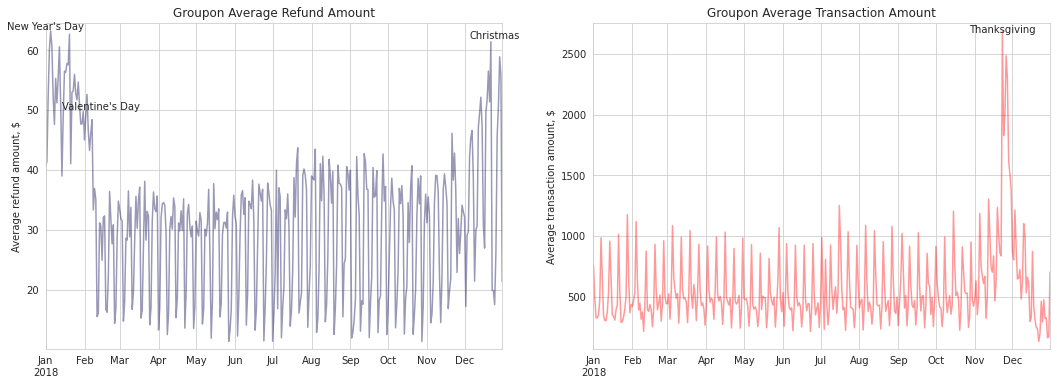

In [42]:
plt.figure()
plt.figure(figsize=(18,6))

# subplot 1
plt.subplot(1,2,1)
avg_data['refunds'].plot(colormap='seismic',alpha=0.4)
plt.text('2018-12-25',62,'Christmas',ha='center')
plt.text('2018-01-01',63.5,"New Year's Day",ha='center')
plt.text('2018-02-14',50,"Valentine's Day",ha='center')
plt.ylabel('Average refund amount, $')
plt.title(r'Groupon Average Refund Amount')
plt.margins(0.010, 0.025)

# subplot 2
plt.subplot(1,2,2)
avg_data['capture_bookings'].plot(colormap='autumn', alpha=0.4)
plt.text('2018-11-23',2675,'Thanksgiving',ha='center')
plt.ylabel('Average transaction amount, $')
plt.title(r'Groupon Average Transaction Amount')
plt.margins(0.010, 0.025)
plt.show()

From the following plots, we can clearly see that refunds and transactions have spikes and valleys. A clear seasnal trend can be detected here. We can observe the biggest transaction spike during Thanksgiving, when most people shop for Christmas gifts. We can also observe the highest amount of refunds during Christmas, New Year's, and Valentine's Day, when people return gifts they didn't like.

In [56]:
refunds_df = subset[['transaction_date', 'refunds']]
refunds_df = refunds_df.resample('D', on='transaction_date').mean()
refunds_df.head()

,refunds
transaction_date,
2018-01-01,40.68
2018-01-02,41.43
2018-01-03,52.07
2018-01-04,60.14
2018-01-05,63.27


<AxesSubplot:xlabel='transaction_date'>

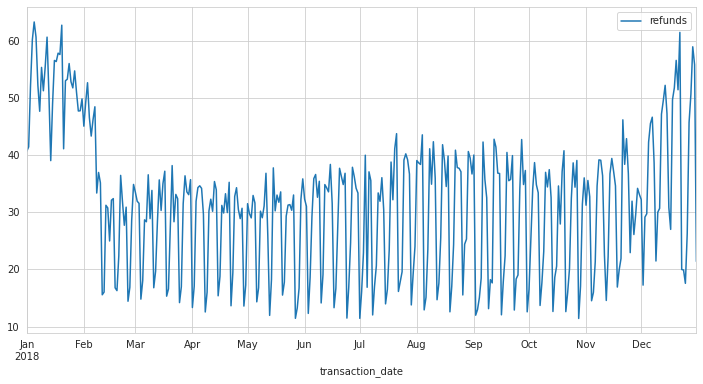

In [57]:
refunds_df.plot(figsize = (12,6))